In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
valid_size = 700

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['train']),
                            ImageFolder('/content/fer_ckplus', data_transforms['train'])])
val_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['val']),
                            ImageFolder('/content/fer_ckplus', data_transforms['val'])])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.datasets[0].targets + train_data.datasets[1].targets,
    stratify=train_data.datasets[0].targets + train_data.datasets[1].targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
from torchvision.ops.misc import Conv2dNormActivation, Permute
import torch.nn.init as init
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
import copy
import math
from torchvision.models.squeezenet import Fire
from functools import partial

In [ ]:
# https://pytorch.org/vision/stable/_modules/torchvision/models/squeezenet.html
class SqueezeNet(nn.Module):
    def __init__(self, version: str = "1_1", num_classes: int = 7, dropout: float = 0.5) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        self.num_classes = num_classes
        if version == "1_0":
            self.features = nn.Sequential(
                nn.Conv2d(1, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == "1_1":
            self.features = nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError(f"Unsupported SqueezeNet version {version}: 1_0 or 1_1 expected")

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

In [ ]:
model = SqueezeNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 70
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]             640
              ReLU-2           [-1, 64, 31, 31]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4           [-1, 16, 15, 15]           1,040
              ReLU-5           [-1, 16, 15, 15]               0
            Conv2d-6           [-1, 64, 15, 15]           1,088
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]           9,280
              ReLU-9           [-1, 64, 15, 15]               0
             Fire-10          [-1, 128, 15, 15]               0
           Conv2d-11           [-1, 16, 15, 15]           2,064
             ReLU-12           [-1, 16, 15, 15]               0
           Conv2d-13           [-1, 64, 15, 15]           1,088
             ReLU-14           [-1, 64,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00005, train_loss: 1.8198, val_loss: 1.7854, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00006, train_loss: 1.6969, val_loss: 1.6615, val_acc: 0.2369


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00009, train_loss: 1.5970, val_loss: 1.5809, val_acc: 0.2456


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00012, train_loss: 1.5538, val_loss: 1.5943, val_acc: 0.2531
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00017, train_loss: 1.5086, val_loss: 1.4850, val_acc: 0.3168


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00022, train_loss: 1.4799, val_loss: 1.4867, val_acc: 0.3187
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00028, train_loss: 1.4500, val_loss: 1.4062, val_acc: 0.3255


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00034, train_loss: 1.4016, val_loss: 1.4404, val_acc: 0.3096


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00041, train_loss: 1.3480, val_loss: 1.3021, val_acc: 0.3777


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00048, train_loss: 1.3147, val_loss: 1.2932, val_acc: 0.3860


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00056, train_loss: 1.2831, val_loss: 1.2635, val_acc: 0.4071


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00063, train_loss: 1.2522, val_loss: 1.1711, val_acc: 0.4308


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00070, train_loss: 1.2304, val_loss: 1.2335, val_acc: 0.4018


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00076, train_loss: 1.2203, val_loss: 1.1964, val_acc: 0.4696
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00082, train_loss: 1.1963, val_loss: 1.1086, val_acc: 0.4765


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00087, train_loss: 1.1743, val_loss: 1.1988, val_acc: 0.4158


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00092, train_loss: 1.1592, val_loss: 1.1242, val_acc: 0.4514


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00095, train_loss: 1.1450, val_loss: 1.1061, val_acc: 0.4552


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00098, train_loss: 1.1316, val_loss: 1.1649, val_acc: 0.4325


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00099, train_loss: 1.1202, val_loss: 1.0772, val_acc: 0.4851


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00100, train_loss: 1.1000, val_loss: 1.0752, val_acc: 0.4939


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00100, train_loss: 1.0774, val_loss: 1.0631, val_acc: 0.4774


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00100, train_loss: 1.0721, val_loss: 1.0227, val_acc: 0.5150


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00099, train_loss: 1.0530, val_loss: 1.0830, val_acc: 0.5117


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00098, train_loss: 1.0433, val_loss: 1.0586, val_acc: 0.5186
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00097, train_loss: 1.0258, val_loss: 1.0272, val_acc: 0.5277
EarlyStopping counter: 2 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00096, train_loss: 1.0150, val_loss: 0.9860, val_acc: 0.5500


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00095, train_loss: 1.0093, val_loss: 0.9695, val_acc: 0.5443


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00094, train_loss: 0.9950, val_loss: 0.9687, val_acc: 0.5390


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00092, train_loss: 0.9869, val_loss: 1.0023, val_acc: 0.5264


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00090, train_loss: 0.9786, val_loss: 0.9951, val_acc: 0.5249


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00088, train_loss: 0.9650, val_loss: 1.0002, val_acc: 0.5398


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00086, train_loss: 0.9632, val_loss: 0.9716, val_acc: 0.5405


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00084, train_loss: 0.9498, val_loss: 0.9316, val_acc: 0.5706


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00081, train_loss: 0.9397, val_loss: 0.9550, val_acc: 0.5318


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00079, train_loss: 0.9298, val_loss: 0.9615, val_acc: 0.5598


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00076, train_loss: 0.9186, val_loss: 0.9329, val_acc: 0.5520


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00073, train_loss: 0.9096, val_loss: 0.9895, val_acc: 0.5515


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00070, train_loss: 0.9035, val_loss: 0.9274, val_acc: 0.5715


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00067, train_loss: 0.8901, val_loss: 0.9177, val_acc: 0.5812


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00064, train_loss: 0.8824, val_loss: 0.9087, val_acc: 0.6043


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00061, train_loss: 0.8754, val_loss: 0.9169, val_acc: 0.5706


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00058, train_loss: 0.8675, val_loss: 0.8924, val_acc: 0.5776


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00055, train_loss: 0.8531, val_loss: 0.9254, val_acc: 0.5616


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00052, train_loss: 0.8488, val_loss: 0.9085, val_acc: 0.5569


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00048, train_loss: 0.8376, val_loss: 0.8648, val_acc: 0.5876


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00045, train_loss: 0.8240, val_loss: 0.8649, val_acc: 0.6021


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00042, train_loss: 0.8197, val_loss: 0.8438, val_acc: 0.6004


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00039, train_loss: 0.8085, val_loss: 0.8664, val_acc: 0.5914


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00036, train_loss: 0.8002, val_loss: 0.8596, val_acc: 0.6157


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00033, train_loss: 0.7872, val_loss: 0.8453, val_acc: 0.6179


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00030, train_loss: 0.7835, val_loss: 0.8739, val_acc: 0.5794


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00027, train_loss: 0.7696, val_loss: 0.8375, val_acc: 0.6093


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00024, train_loss: 0.7586, val_loss: 0.8128, val_acc: 0.6206


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00021, train_loss: 0.7545, val_loss: 0.8329, val_acc: 0.5979


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00019, train_loss: 0.7473, val_loss: 0.8371, val_acc: 0.6127


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00016, train_loss: 0.7314, val_loss: 0.8500, val_acc: 0.6112


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00014, train_loss: 0.7241, val_loss: 0.8189, val_acc: 0.6116


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00012, train_loss: 0.7204, val_loss: 0.7992, val_acc: 0.6350


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00010, train_loss: 0.7143, val_loss: 0.8539, val_acc: 0.5754


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00008, train_loss: 0.7094, val_loss: 0.8051, val_acc: 0.6219


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00006, train_loss: 0.7000, val_loss: 0.8201, val_acc: 0.6147


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00005, train_loss: 0.6960, val_loss: 0.8002, val_acc: 0.6249


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00004, train_loss: 0.6924, val_loss: 0.7970, val_acc: 0.6325


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00003, train_loss: 0.6881, val_loss: 0.8372, val_acc: 0.6143


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00002, train_loss: 0.6850, val_loss: 0.8001, val_acc: 0.6351
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00001, train_loss: 0.6806, val_loss: 0.7664, val_acc: 0.6385


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00000, train_loss: 0.6825, val_loss: 0.8202, val_acc: 0.6127


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00000, train_loss: 0.6812, val_loss: 0.7804, val_acc: 0.6395
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00000, train_loss: 0.6833, val_loss: 0.8216, val_acc: 0.6343
Training complete in 61m 22s
Best val Acc: 0.639473


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.5612 , roc: 0.8938 , f1: 0.5201 , recall: 0.5511


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.6594 , roc: 0.9497 , f1: 0.6753 , recall: 0.6985


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/squeezenetraf.pt')

In [ ]:
print(results)

{'acc': [0.14285714285714285, 0.2369170643013422, 0.2456030504684341, 0.2531048805264328, 0.31679772480438156, 0.318747466348805, 0.325460439755641, 0.3095552687360393, 0.3777138224143662, 0.38601119125917327, 0.4071437904526822, 0.43075108817384017, 0.401813978421004, 0.46963411530572735, 0.4764576827219242, 0.415824004164726, 0.4513829686785828, 0.4552090933002721, 0.43252704919991175, 0.4851443657837282, 0.49394113698171616, 0.47741959477789014, 0.5149765715068668, 0.5117151783130509, 0.5186456166277155, 0.5277108658686727, 0.5500066307342586, 0.5442789084048308, 0.5389973712649493, 0.5263642014548496, 0.5248946200544301, 0.5397764310775182, 0.5405141266316942, 0.5706244250814045, 0.5317774428957871, 0.5598375721105793, 0.5519870848140177, 0.5514738491560768, 0.5715367060328751, 0.5811541687833418, 0.6043250318666153, 0.5706436636389948, 0.577636259764894, 0.5616389695758894, 0.5568702779883536, 0.5875686141571028, 0.6021096710472615, 0.6004239582940076, 0.5913909039427464, 0.615684

In [ ]:
results = {'acc': [0.14285714285714285, 0.2369170643013422, 0.2456030504684341, 0.2531048805264328, 0.31679772480438156, 0.318747466348805, 0.325460439755641, 0.3095552687360393, 0.3777138224143662, 0.38601119125917327, 0.4071437904526822, 0.43075108817384017, 0.401813978421004, 0.46963411530572735, 0.4764576827219242, 0.415824004164726, 0.4513829686785828, 0.4552090933002721, 0.43252704919991175, 0.4851443657837282, 0.49394113698171616, 0.47741959477789014, 0.5149765715068668, 0.5117151783130509, 0.5186456166277155, 0.5277108658686727, 0.5500066307342586, 0.5442789084048308, 0.5389973712649493, 0.5263642014548496, 0.5248946200544301, 0.5397764310775182, 0.5405141266316942, 0.5706244250814045, 0.5317774428957871, 0.5598375721105793, 0.5519870848140177, 0.5514738491560768, 0.5715367060328751, 0.5811541687833418, 0.6043250318666153, 0.5706436636389948, 0.577636259764894, 0.5616389695758894, 0.5568702779883536, 0.5875686141571028, 0.6021096710472615, 0.6004239582940076, 0.5913909039427464, 0.6156844635697895, 0.617944743014923, 0.5794420527020602, 0.6092709812992274, 0.6206460568576472, 0.5978824280916584, 0.6127260867562763, 0.6111699506350637, 0.6116328881653396, 0.6350031935660541, 0.5753767649418887, 0.6218528270756386, 0.6147165590478852, 0.6248629031094145, 0.6325191568033658, 0.6143281470854761, 0.6350856017370675, 0.638543271780504, 0.6127442195977816, 0.639473206489772, 0.6342612640808571], 'f1': [0.06737367436057393, 0.1915161673681096, 0.214699291559926, 0.1892971102601654, 0.27822003020254943, 0.29296678043816843, 0.3057817303100952, 0.28588214984289667, 0.3517604736635029, 0.3576558661333301, 0.36622052874042355, 0.42548855507191885, 0.38869911439664195, 0.47457906723782756, 0.4831112928103373, 0.4033635353743375, 0.4605646087653377, 0.45906639411298905, 0.42463478748021316, 0.4952151171993939, 0.49676294915577807, 0.46100352015118146, 0.5139664393554606, 0.5032369177499475, 0.53374072380138, 0.526148417392899, 0.5550357409514934, 0.5594470503052226, 0.549405003228249, 0.5261412432341557, 0.5461242911475396, 0.5558401255914279, 0.5571697791238363, 0.578499717326992, 0.5416391236130116, 0.5721549392117428, 0.5609374449080331, 0.5554543965818344, 0.5805499175254825, 0.5888817289893586, 0.6176099976557108, 0.5869241625187771, 0.5856322293291066, 0.5792986453080224, 0.5656099611146783, 0.6011602882235525, 0.6164140817368601, 0.6129693604221329, 0.6145474927964357, 0.6329426652801203, 0.6296881953818331, 0.5925133910105471, 0.6249064370518488, 0.6418788570412232, 0.620793225814662, 0.6270843172855561, 0.6288881581149911, 0.6313767806309504, 0.6506622556502512, 0.5898335949949408, 0.6391751396869482, 0.6269155699288386, 0.6402534407168236, 0.6556462592742118, 0.6314060181060516, 0.647404856814671, 0.654249546318449, 0.626891825924793, 0.6576390957001281, 0.6481175247109466], 'rec': [0.04408163265306122, 0.1876480164715459, 0.19996732113520435, 0.21771435847066098, 0.2632687254258726, 0.3273564615846495, 0.30023169486902873, 0.39150281970593825, 0.3432304659795827, 0.3526479170141298, 0.3596831590309852, 0.48090529016444694, 0.4129473085872248, 0.5498913869925935, 0.5109625914118003, 0.5506507459607969, 0.5818671657284468, 0.5106433167612745, 0.6858679620646928, 0.5361145240971845, 0.5784978500409618, 0.5797499181061555, 0.6102096625142363, 0.5507150790163523, 0.5889780321550045, 0.610304378161521, 0.6773513264570544, 0.6335884753337401, 0.6923463988371983, 0.6463085957248753, 0.6474938851805303, 0.6192313820646612, 0.6467751296812736, 0.6180002822063165, 0.5843164194927917, 0.6654855604809674, 0.5909045682022492, 0.6264413835731071, 0.6214485461960123, 0.6335067019202122, 0.6560430276230671, 0.6247232184474961, 0.6083888131348342, 0.6313363953144059, 0.619367959571722, 0.6522673232894436, 0.6463739289810516, 0.6727974447319419, 0.6985796398997001, 0.6716582903926263, 0.6708065536587189, 0.6542358224754433, 0.6596907319534985, 0.7158995990250807, 0.6749296635367321, 0.6743114719901759, 0.6816105803689954, 0.7072136026877732, 0.6899352232238088, 0.644325934336789, 0.6793586457131592, 0.6575879755784879, 0.6784480806468977, 0.7356746017540524, 0.6740370911486869, 0.6780162329488734, 0.684430094997068, 0.6636934304629919, 0.7101538500474508, 0.6855678028426163], 'prec': [0.14285714285714285, 0.2369170643013422, 0.2456030504684341, 0.2531048805264328, 0.31679772480438156, 0.318747466348805, 0.325460439755641, 0.3095552687360393, 0.3777138224143662, 0.38601119125917327, 0.4071437904526822, 0.43075108817384017, 0.401813978421004, 0.46963411530572735, 0.4764576827219242, 0.415824004164726, 0.4513829686785828, 0.4552090933002721, 0.43252704919991175, 0.4851443657837282, 0.49394113698171616, 0.47741959477789014, 0.5149765715068668, 0.5117151783130509, 0.5186456166277155, 0.5277108658686727, 0.5500066307342586, 0.5442789084048308, 0.5389973712649493, 0.5263642014548496, 0.5248946200544301, 0.5397764310775182, 0.5405141266316942, 0.5706244250814045, 0.5317774428957871, 0.5598375721105793, 0.5519870848140177, 0.5514738491560768, 0.5715367060328751, 0.5811541687833418, 0.6043250318666153, 0.5706436636389948, 0.577636259764894, 0.5616389695758894, 0.5568702779883536, 0.5875686141571028, 0.6021096710472615, 0.6004239582940076, 0.5913909039427464, 0.6156844635697895, 0.617944743014923, 0.5794420527020602, 0.6092709812992274, 0.6206460568576472, 0.5978824280916584, 0.6127260867562763, 0.6111699506350637, 0.6116328881653396, 0.6350031935660541, 0.5753767649418887, 0.6218528270756386, 0.6147165590478852, 0.6248629031094145, 0.6325191568033658, 0.6143281470854761, 0.6350856017370675, 0.638543271780504, 0.6127442195977816, 0.639473206489772, 0.6342612640808571], 'roc': [0.542620438282645, 0.6387237119224419, 0.6847288563477292, 0.7155359676951681, 0.7346607383780661, 0.7410843846919805, 0.7895207743463387, 0.7810037312113023, 0.815513560196077, 0.818288682082575, 0.842993571237667, 0.8536795319166456, 0.8483478323395767, 0.8564630577578356, 0.8716075984598053, 0.8504016019677673, 0.8697337262707522, 0.8708749620336204, 0.8626477577800838, 0.8781196169537064, 0.8774381469768985, 0.8836230532490131, 0.888342673949688, 0.8784361576430556, 0.8830516924227549, 0.8959389233258087, 0.9024766581554181, 0.8988340524483458, 0.9022122748510669, 0.8981062178919059, 0.8967224544119375, 0.9002328180895646, 0.9009779890020816, 0.908441222299646, 0.9029496216121433, 0.9044422045865634, 0.9110414560616978, 0.9003453942166103, 0.9145167626850449, 0.9124068004255325, 0.914718093041169, 0.9135403627955491, 0.9155160798485389, 0.9162785895984796, 0.9161375004446235, 0.918021686156864, 0.920913524427119, 0.9258494817290701, 0.922823742138057, 0.9216891587999222, 0.9256755167457849, 0.9227860950623269, 0.9268181312866332, 0.9338064899706453, 0.926986873144207, 0.9264453683475757, 0.9268742323157884, 0.9273885520786324, 0.9351320920210521, 0.9226221964294672, 0.931888413457702, 0.9325705389810618, 0.9331474573136486, 0.9309520948602759, 0.9260400835221729, 0.9334363022582892, 0.9400424210115205, 0.9300097512477611, 0.9356446887802231, 0.9297846844987181]}


In [ ]:
criterion = nn.CrossEntropyLoss()
model = SqueezeNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/squeezenetraf.pt'))
model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.7082 , roc: 0.9487 , f1: 0.6855 , recall: 0.7534


In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

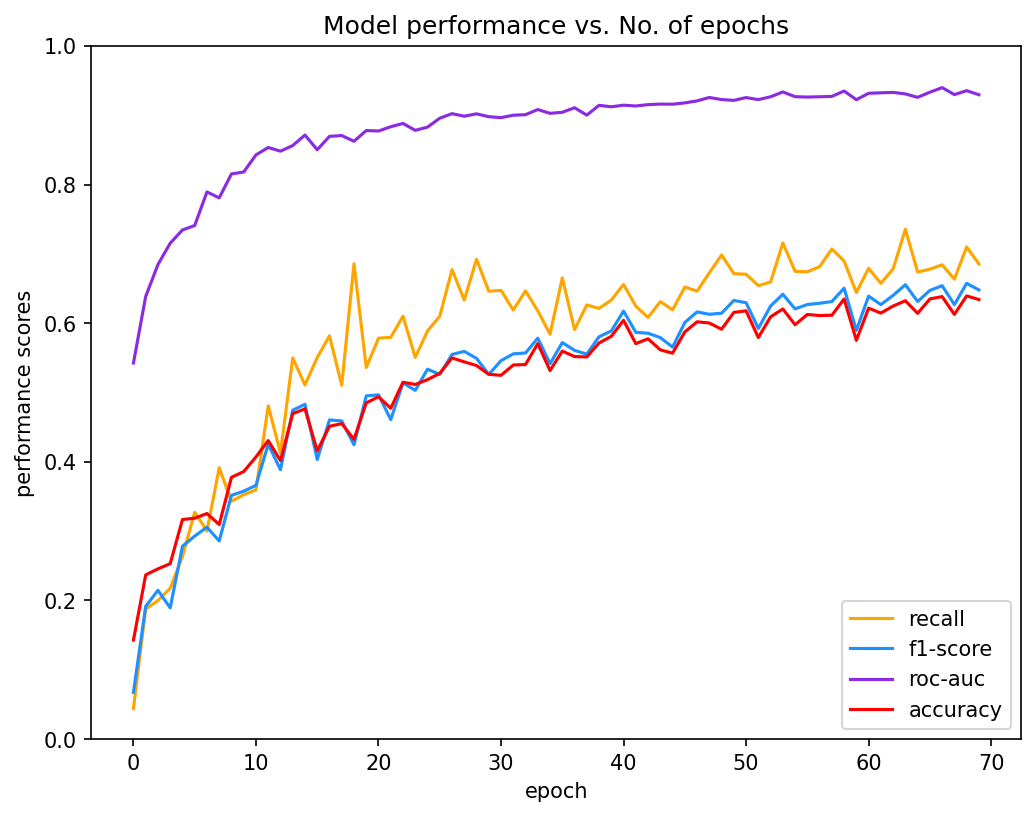

In [ ]:
plot_scores(results)

In [ ]:
#source for timing the model execution: https://deci.ai/blog/measure-inference-time-deep-neural-networks/
dummy_input = torch.randn(1,1,64,64, dtype=torch.float).to(device)

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 10000
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print("Avg prediction time:", round(mean_syn,3), "Sd:", round(std_syn,3))

Avg prediction time: 2.387 Sd: 0.547
